In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math 

In [2]:
class ResNet3:
    INsize = 1
    HD1size = 1
    HD2size = 1
    OUTsize = 1
    W1 = [[0]]
    W2 = [[0]]
    Wres = [[0]]
    Wout = [[0]]
    B1 = [0]
    B2 = [0]
    B3 = [0]
    
    def ReLu(self,x):
        mask = (x>0) * 1.0
        return mask *x

    def d_ReLu(self,x):
        mask = (x>0) * 1.0
        return mask 
    
    def tanh(self,x):
        return np.tanh(x)

    def d_tanh(self,x):
        return 1.0 - self.tanh(x)**2       
    
    def softmax(self, X, theta = 1.0, axis = None):
        """
        Compute the softmax of each element along an axis of X.
        Parameters
        ----------
        X: ND-Array. Probably should be floats. 
        theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
        axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.
        Returns an array the same size as X. The result will sum to 1
        along the specified axis.
        """
        # make X at least 2d
        y = np.atleast_2d(X)
        # find axis
        if axis is None:
            axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
        # multiply y against the theta parameter, 
        y = y * float(theta)
        # subtract the max for numerical stability
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        # exponentiate y
        y = np.exp(y)
        # take the sum along the specified axis
        ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
        # finally: divide elementwise
        p = y / ax_sum
        # flatten if X was 1D
        if len(X.shape) == 1: p = p.flatten()
        return p    
    
    def d_softmax(self, x):
        J = - x[..., None] * x[:, None, :]
        iy, ix = np.diag_indices_from(J[0])
        J[:, iy, ix] = x * (1. - x)
        return np.sum(J, axis = 1)    

    def xavier_trick(self,size):
        if len(size) ==2:
            c = np.sqrt(size[0]*size[1])*1e3
            result = np.random.random(size)/c
        else:
            size = size[0]
            c = np.sqrt(size)*1e3
            result = np.random.random(size)/c            
        return result
    
    def init(self):
        self.W1 = self.xavier_trick(size = (self.INsize, self.HD1size))
        self.W2 = self.xavier_trick(size = (self.HD1size, self.HD2size))
        self.Wout = self.xavier_trick(size = (self.HD2size, self.OUTsize))
        self.Wres = self.xavier_trick(size = (self.INsize, self.OUTsize))
        self.B1 = self.xavier_trick(size = (self.HD1size,))
        self.B2 = self.xavier_trick(size = (self.HD2size,))
        self.B3 = self.xavier_trick(size = (self.OUTsize,))
    
    def forward_pass(self, X):
        l0 = X
        l1 = self.tanh(np.dot(l0, self.W1) + self.B1)
        l2 = self.ReLu(np.dot(l1, self.W2) + self.B2)
        if self.isSoftMax:
            l3 = self.softmax(np.dot(l2, self.Wout)+np.dot(l0, self.Wres) + self.B3,theta = 0.5, axis = 1)
        else:            
            l3 = self.tanh(np.dot(l2, self.Wout)+np.dot(l0, self.Wres) + self.B3)        
        return l0, l1, l2, l3
        
    def cross_entropy(self, p, y):
        m = y.shape[0]
        log_likelihood = -np.log(p[range(m),np.argmax(y, axis = 1)])
        result = np.sum(log_likelihood)/m
        return result    
    
    def delta_cross_entropy(self, grad, y):
        m = y.shape[0]
        grad[range(m),np.argmax(y, axis = 1)] -= 1
        grad = grad/m
        return grad    
    
    def backward_pass(self, l0, l1, l2, l3, y):        
        l3_delta = self.delta_cross_entropy(l3, y)
        l2_error = l3_delta.dot(self.Wout.T)    
        l2_delta = l2_error*self.d_ReLu(l2)
        l1_error = l2_delta.dot(self.W2.T)
        l1_delta = l1_error*self.d_tanh(l1)
        self.Wout -= self.learning_rate * l2.T.dot(l3_delta)
        self.Wres -= self.learning_rate * l0.T.dot(l3_delta)
        self.W2 -= self.learning_rate * l1.T.dot(l2_delta)
        self.W1 -= self.learning_rate * l0.T.dot(l1_delta)    
        self.B3 -= self.learning_rate * np.sum(l3_delta, axis=0)
        self.B2 -= self.learning_rate * np.sum(l2_delta, axis=0)
        self.B1 -= self.learning_rate * np.sum(l1_delta, axis=0)
    
    def fit(self, X, y, lr=0.1, isSoftMax=True):
        self.isSoftMax = isSoftMax
        self.learning_rate = lr
        l0, l1, l2, l3 = self.forward_pass(X)
        self.out_error = self.cross_entropy(l3, y)
        self.backward_pass(l0, l1, l2, l3, y)
        
    def predict(self, X, isSoftMax=True):
        l0, l1, l2, l3 = self.forward_pass(X)
        return l3
    
    def reset(self):
        self.init()
    
    def __init__(self, input_size=2, layer1_size = 12, layer2_size = 12, output_size = 12):
        self.INsize = input_size
        self.HD1size = layer1_size
        self.HD2size = layer2_size
        self.OUTsize = output_size  
        self.init()

In [3]:
def one_hot_encoding(y):
    if np.min(y) > 0:
        y = y-1
    max_val = np.max(y) + 1
    size = len(y)
    result = np.zeros((size, max_val))
    result[np.arange(size), y] = 1
    return result.astype(int)

def normalize(x):
    return (x-min(x))/(max(x)-min(x))

In [4]:
def shuffle_split_data(X, y):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, 70)

    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, y_train, X_test, y_test

In [5]:
def accuracy(y_pred, y_true):
    x_cl = [np.argmax(pred)+1 for pred in y_pred]
    y_cl = [np.argmax(pred)+1 for pred in y_true]
    res = 0
    idx = 0
    for xc, yc in zip(x_cl, y_cl):
        res += 0 if xc == yc else 1
    return ((len(x_cl) - res)/len(x_cl))*100

In [6]:
def eval_model(model, X_train, y_train, X_test, y_test, lr = 0.1, batch_size = 10, isSoftMax = True):
    epochs = 10
    accuracy_by_epoch = []
    error_by_epoch = []
    batch_count = int(np.ceil(len(X_train)/batch_size))
    for epoch in range(epochs):
        for batch_number in range(batch_count):
            batch_offset = batch_number*batch_size
            batch_X = X_train[batch_offset:min(batch_offset+batch_size, X_train.shape[0]),:]
            batch_y = y_train[batch_offset:min(batch_offset+batch_size, y_train.shape[0]),:]
            #print("Batch #{} len {}".format(batch_number+1, len(batch_X)))
            model.fit(batch_X, batch_y, lr = 0.1, isSoftMax = isSoftMax)
        y_pred = model.predict(X_test)
        acc = accuracy(y_pred, y_test)
        accuracy_by_epoch.append(acc)
        err = np.mean(np.abs(model.out_error))
        error_by_epoch.append(err)
    return error_by_epoch, accuracy_by_epoch

In [7]:
np.random.seed(42)
data = np.genfromtxt("dataset/wine.data", delimiter=",")
y = one_hot_encoding(data[:,0].astype(int))
X = data[:,1:]
for r in range(X.shape[1]):
    X[:,r] = normalize(X[:,r])
X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
print("Train/test split: {}/{}".format(len(X_train), len(X_test)))
model = ResNet3(input_size=X_train.shape[1], layer1_size = 7, layer2_size = 9, output_size = y_train.shape[1])

Train/test split: 124/54


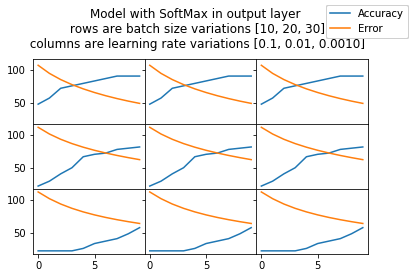

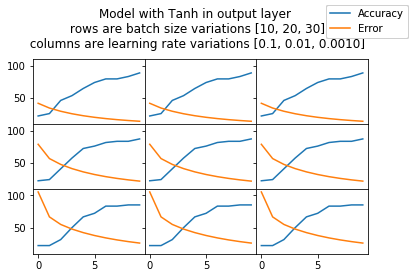

In [22]:
isSoftMax_vals = [True, False]
batch_size_vals = [10, 20, 30]
learning_rate_vals = [0.1, 0.01, 0.001]

for isSoftMax in isSoftMax_vals:
    f, axarr = plt.subplots(3, 3, sharex=True, sharey=True)
    f.suptitle("Model with "+('SoftMax' if isSoftMax else 'Tanh') + " in output layer" + 
               "\n rows are batch size variations [10, 20, 30]" + 
              "\n columns are learning rate variations [0.1, 0.01, 0.0010]")
    l1 = None
    l2 = None
    for batch_size in batch_size_vals:
        for learning_rate in learning_rate_vals:
            model.reset()
            error_by_epoch, accuracy_by_epoch = eval_model(model, X_train, y_train, X_test, y_test, learning_rate, 
                                                           batch_size, isSoftMax)
            bsl = len(batch_size_vals)
            lrl = len(learning_rate_vals)
            plt_row, plt_col = batch_size_vals.index(batch_size), learning_rate_vals.index(learning_rate)
            #l1 = axarr[plt_row, plt_col].plot(accuracy_by_epoch)
            x = np.arange(0, 10, 1)
            l1, l2 = axarr[plt_row, plt_col].plot(x, accuracy_by_epoch, x, [error*100 for error in error_by_epoch])
            #l2 = axarr[plt_row, plt_col].plot([error*100 for error in error_by_epoch])
            f.legend((l1, l2), ('Accuracy', 'Error'), 'upper right')
    f.subplots_adjust(top = 0.8, hspace=0, wspace=0)
    for axrows in axarr:
        for ax in axrows:
            ax.label_outer()    